This notebook will train a model using Q-tensor input rather than a director input

In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from numba import jit
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
class Qsim:
    def __init__(self,nsteps,L):
        # number of grad spacings in x,y
        self.Lx = L
        self.Ly = L

        # phase free energy density constants and elastic constant (single constant approximation)
        self.A = -1
        self.C = 1.5
        self.S0 = np.sqrt(-self.A/(2*self.C))
        self.L = 1

        # gradient descent minimizer
        self.Gamma = 0.2

        # stopping condition
        self.Hsize_stop = 0.1#10e-5

        self.printstep = nsteps
        self.plotstep = nsteps
        # declare an Lx x Ly x 2 array, to store (Qxx,Qxy) at each site
        # initialize Q with random values between -S0 and S0
        self.Q = self.S0*2*(np.random.rand(self.Lx,self.Ly,2)-0.5)

    def Q_from_n(self,nx,ny):
	    #set the initial condition to be the top
        Q_at_xy = np.zeros(2)
        Q_at_xy[0] = 1.5*nx*nx-0.5 #xx
        Q_at_xy[1] = 1.5*nx*ny
        return Q_at_xy
     
    def set_initial_condition(self):
        for x in np.arange(0,self.Lx):
            self.Q[x,0] = self.Q_from_n(1,0) # y bottom
            self.Q[x,-1] = self.Q_from_n(1,0) # y top
        for y in np.arange(0,self.Ly):
            self.Q[0,y] = self.Q_from_n(0,1) # x bottom
            self.Q[-1,y] = self.Q_from_n(1,0) # x top

    #@jit(nopython=True)
    def trQsq(self,Qxx,Qxy):
        return(2*(Qxx*Qxx+Qxy*Qxy))    

    def trace_Q_squared(self,Qxx,Qxy):
        return(2*(Qxx*Qxx+Qxy*Qxy))  

    def get_director(self):
        S = np.zeros((self.Lx,self.Ly))
        nx = np.zeros((self.Lx,self.Ly))
        ny = np.zeros((self.Lx,self.Ly))
        for x in np.arange(0,self.Lx):
            for y in np.arange(0,self.Ly):
                S[x,y] = 0.5*np.sqrt(self.trace_Q_squared(self.Q[x,y,0],self.Q[x,y,1]))
                a = self.Q[x,y,0]
                b = self.Q[x,y,1]
                eigenvalues,eigenvectors = np.linalg.eig(np.array([[a,b],[b,-a]]))
                nx[x,y] = eigenvectors[0,np.argmax(eigenvalues)]
                ny[x,y] = eigenvectors[1,np.argmax(eigenvalues)]
        return S,nx,ny

    def update_plot(self,b_made_colorbar):
        # plot of director field and order updates every printstep timesteps
        S,nx,ny = self.get_director()
        norm = cm.colors.Normalize(vmax=1,vmin=0)
        plt.pcolormesh(S/self.S0,norm=norm)
        if not b_made_colorbar:
            plt.colorbar(label="S/S0")
        plt.quiver(nx,ny,headwidth=0,units='x',scale=1,pivot='mid')
        plt.ion()
        plt.draw()
        plt.pause(0.001)

    def update_plot_with_defects(self,b_made_colorbar,defect_locs):
        # plot of director field and order updates every printstep timesteps
        S,nx,ny = self.get_director()
        norm = cm.colors.Normalize(vmax=1,vmin=0)
        plt.pcolormesh(S/self.S0,norm=norm)
        if not b_made_colorbar:
            plt.colorbar(label="S/S0")
        plt.quiver(nx,ny,headwidth=0,units='x',scale=1,pivot='mid')
        defect_locations = np.array(defect_locs)
        plt.scatter(defect_locations[:,0],defect_locations[:,1],color="tab:red",marker=",")
        plt.ion()
        plt.draw()
        plt.pause(0.001)
        
    #@jit(nopython=True)
    def calc_Q(self,F,H,Hsize):
        for x in np.arange(0,self.Lx):
            for y in np.arange(0,self.Ly):
                trQ2 = self.trQsq(self.Q[x,y,0],self.Q[x,y,1])
                f_bulk = 0.5*self.A*trQ2 + 0.25*self.C*trQ2*trQ2
                xp1 = (x+1)%self.Lx
                xm1 = (x-1)%self.Lx
                yp1 = (y+1)%self.Ly
                ym1 = (y-1)%self.Ly
                dxQ = 0.5*(self.Q[xp1,y]-self.Q[xm1,y])
                dx2Q = self.Q[xp1,y] - 2*self.Q[x,y]+ self.Q[xm1,y]
                dyQ = 0.5*(self.Q[x,yp1]-self.Q[x,ym1])
                dy2Q = self.Q[x,yp1] - 2*self.Q[x,y]+ self.Q[x,ym1]
                f_distortion = self.L*(dxQ[0]*dxQ[0] + dxQ[1]*dxQ[1] + dyQ[0]*dyQ[0] + dyQ[1]*dyQ[1])
                F = F + f_bulk + f_distortion
                Laplacian_Q = dx2Q + dy2Q
                H[x,y] = self.L*Laplacian_Q - self.Q[x,y]*(self.A+0.5*self.C*trQ2)
                Hsize = Hsize + (H[x,y,0]*H[x,y,0] + H[x,y,1]*H[x,y,1])
        return F,H,Hsize

    def find_defects_using_model(self,model):
        _,nx,ny = self.get_director()
        defect_highlighted_x = np.lib.stride_tricks.sliding_window_view(nx,(3,3))
        defect_highlighted_y = np.lib.stride_tricks.sliding_window_view(ny,(3,3))
        defects_found = 0
        defect_locations = []
        for i in range(defect_highlighted_x.shape[0]):
            for j in range(defect_highlighted_y.shape[1]):
                defect_highlighted_field = np.zeros((3,3,2))
                defect_highlighted_field[:,:,0] = defect_highlighted_x[i,j]
                defect_highlighted_field[:,:,1] = defect_highlighted_y[i,j]
                test_tensor = torch.tensor(defect_highlighted_field.flatten(), dtype=torch.float32).unsqueeze(0)

                # Make a prediction
                with torch.no_grad():
                    model.eval()
                    output = model(test_tensor)
                    prediction = torch.argmax(output,dim=1)
                defect_types = ["No Defect", "+1/2 Defect", "-1/2 Defect"]
                label = defect_types[prediction.item()]
                if prediction.item() > 0:
                    #print("Prediction:", label,prediction.item(),"loc:",j+1,i+1)
                    defect_locations.append([j+1,i+1])
                    defects_found += 1
        print("Defects Found:",defects_found)
        return defect_locations

    def run_simulation(self,model=None,boundary=False):
        if model == None:
            print("No defect finding")
        else:
            print("Defect finding turned on")
        
        b_stop_search = False
        b_made_colorbar = False
        stepnum = 0

        print("stepnum\t Hsize\t F")

        # loop for relaxation steps
        if boundary:
            self.set_initial_condition()
        self.update_plot(b_made_colorbar)
        b_made_colorbar = True
        while not b_stop_search:
            H = np.zeros((self.Lx,self.Ly,2))
            F = 0
            Hsize = 0
            F,H,Hsize = self.calc_Q(F,H,Hsize)

            Hsize = np.sqrt(Hsize)
            #update
            self.Q = self.Q + self.Gamma*H
            if boundary:
                self.set_initial_condition()
            stepnum = stepnum+1

            #stopping condition
            if (Hsize <= self.Hsize_stop):
                b_stop_search = True
                print(f'Success: reached stopping condition Hsize = {Hsize} <= {self.Hsize_stop}')

            # monitor progress
            if (stepnum%self.printstep) == 0:
                print(f'{stepnum}\t {Hsize}\t {F}')
            if (stepnum%self.plotstep) == 0:
                if model != None:
                    defect_locs = self.find_defects_using_model(model)
                    self.update_plot_with_defects(b_made_colorbar,defect_locs)
                else:
                    self.update_plot(b_made_colorbar)
                b_made_colorbar = True
        print(f'Done')

No defect finding
stepnum	 Hsize	 F


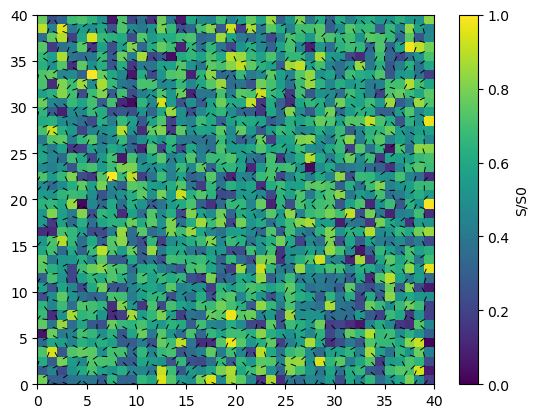

100	 1.269623521818622	 -5.8370130866573495


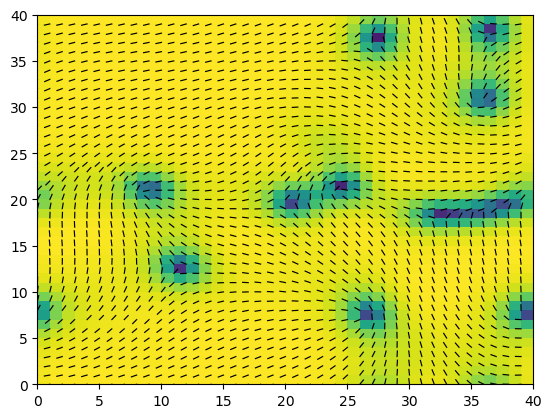

200	 0.8906817605702066	 -3.169984142693128


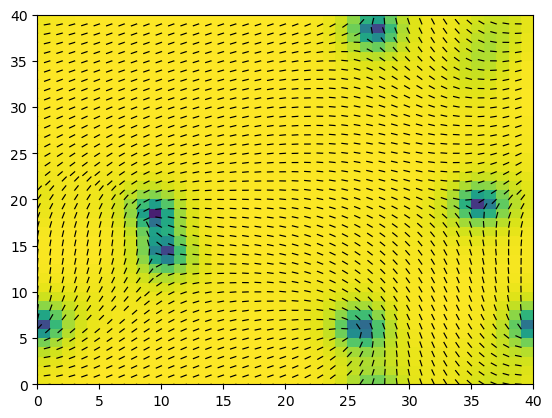

300	 0.6691866974388733	 -1.3848379133385011


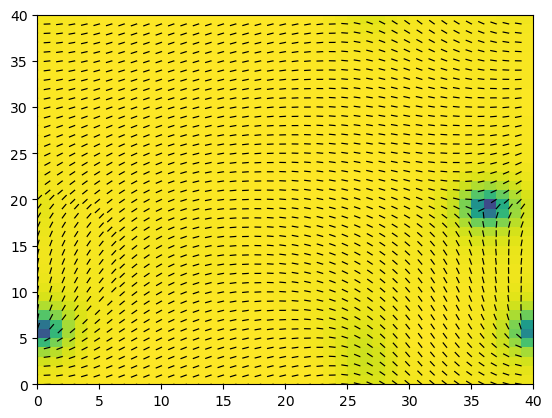

400	 0.2832809035495107	 -0.7486855904282635


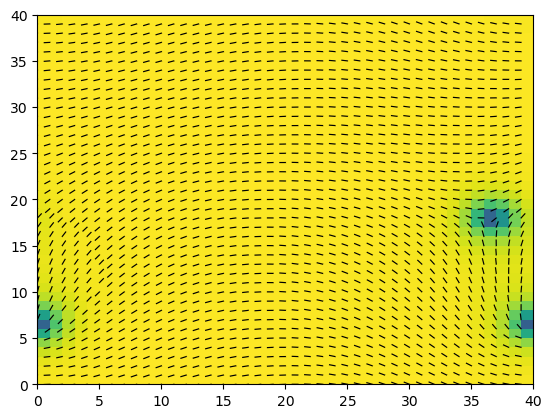

500	 0.33076750425304063	 -0.7697917211643781


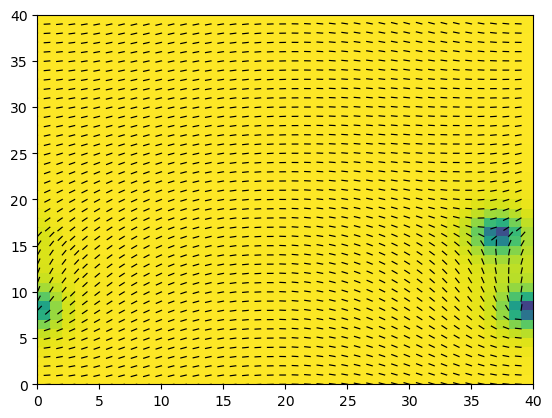

600	 0.707403187854279	 -0.8336473203253183


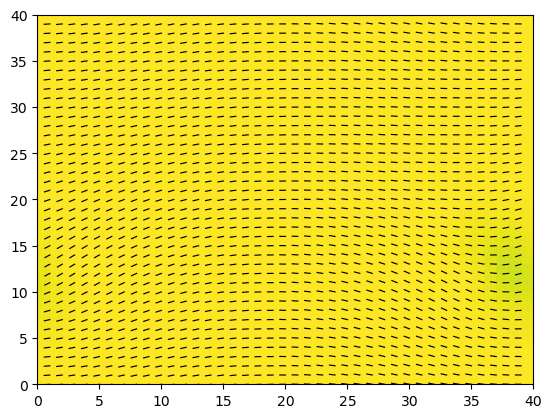

700	 0.20852849538252288	 -0.051000884438459355


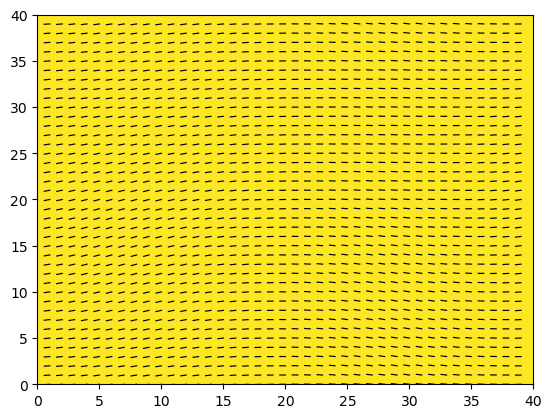

800	 0.11664775804643333	 -0.01589726694836059


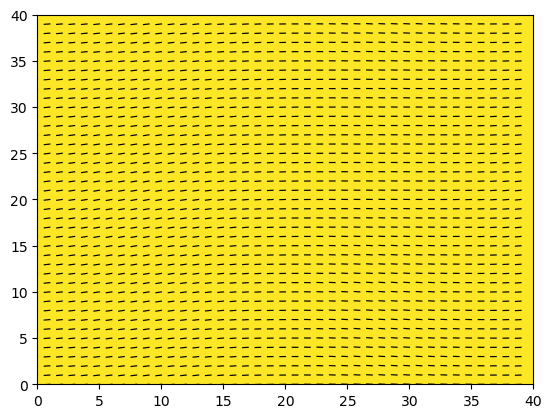

Success: reached stopping condition Hsize = 0.09993493740267721 <= 0.1
Done


In [9]:
sim = Qsim(100,40)
sim.run_simulation()